In [115]:
import energyflow as ef
from energyflow.datasets.mod import MODDataset
import energyflow.emd
import numpy as np

from matplotlib import animation
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from IPython.display import HTML

import utils

In [2]:
%time cms = MODDataset('CMS_Jet300_pT375-infGeV', path=utils.path('cms', 'h5'))

CPU times: user 1.53 s, sys: 4.51 s, total: 6.04 s
Wall time: 6.02 s


In [414]:
print(x, y, z)

205.79728824557012 158.72016840509085 122.52368512116543


In [356]:
R = 0.5

def plot_event(event, offset=(0, 0), scale=1., ax=None, box=False, color='black', 
               show=True, process=True, axes_opts=True, zorder=1):
    
    if process:
        event = ef.rotate_ptyphims(event, center='escheme')
        event = event[np.linalg.norm(event[:,1:3], axis=1) <= R]
    
    if ax is None:
        ax = plt.gca()
        
    scatter = ax.scatter(event[:,1]*scale + offset[0], 
                         event[:,2]*scale + offset[1], 
                         s=zf*event[:,0], lw=0, color=color, zorder=zorder)
    
    if axes_opts:
        ax.set_xlim(-R, R); ax.set_ylim(-R, R)
        ax.set_xticks([]); ax.set_yticks([])
    
    if not box:
        ax.set_axis_off()
    
    if show:
        plt.show()
        
    return scatter
        
def merge(ev0, ev1, G, t):
    
    # handle 0 and 1 cases separately
    if t == 0.:
        return ev0[:,:3]
    
    if t == 1.:
        return ev1[:,:3]
    
    merged = []
    for i in range(len(ev0)):
        for j in range(len(ev1)):
            if G[i, j] > 0:
                merged.append([G[i,j], (1-t)*ev0[i,1] + t*ev1[j,1], (1-t)*ev0[i,2] + t*ev1[j,2]])
            
    for i in range(len(ev0)):
        if G[i,-1] > 0:
            merged.append([G[i,-1]*(1-t), ev0[i,1], ev0[i,2]])

    for j in range(len(ev1)):
        if G[-1,j] > 0:
            merged.append([G[-1,j]*t, ev1[j,1], ev1[j,2]])            
            
    return np.asarray(merged)

def proc_event(event):
    event = ef.rotate_ptyphims(event, center='escheme')
    return event[np.linalg.norm(event[:,1:3], axis=1) <= R]
        
def animate_between_events(ev0, ev1, 
                           color0=(1,0,0), color1=(0,0,1),
                           box=True,
                           fps=50, nsec=10, dpi=200,
                           filepath=None):
    
    ev0, ev1 = proc_event(ev0), proc_event(ev1)
    
    # get emd plan between events
    emd, G = ef.emd.emd(ev0, ev1, R=R, return_flow=True, gdim=2)
    
    # colors
    color0, color1 = np.asarray(color0), np.asarray(color1)
    
    fig, ax = plt.subplots()
    fig.subplots_adjust(left=0.01, bottom=0.01, top=.99, right=.99, wspace=None, hspace=None)
    
    nframes = fps*nsec
    def animate(i):
        
        ax.clear()
        
        # at rest for first quarter
        if i < nframes/4:
            scatter = plot_event(ev0, ax=ax, box=box, show=False, color=color0, process=False)
            
        # moving for second quarter
        elif i < 2*nframes/4:
            t = (i - nframes/4)/(nframes/4)
            color = t*color1 + (1-t)*color0
            scatter = plot_event(merge(ev0, ev1, G, t), color=color, ax=ax, box=box, show=False, process=False)
            
        # paused for third quarter
        elif i < 3*nframes/4:
            scatter = plot_event(ev1, ax=ax, box=box, show=False, color=color1, process=False)
            
        # moving for fourth quarter
        else:
            t = (nframes - i)/(nframes/4)
            color = t*color1 + (1-t)*color0
            scatter = plot_event(merge(ev0, ev1, G, t), color=color, ax=ax, box=box, show=False, process=False)
            
        return scatter
    
    anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=True, interval=1000/fps)
    
    if filepath is not None:
        if not filepath.endswith('.mp4'):
            filepath += '.mp4'
            
        anim.save(filepath, fps=fps, dpi=dpi)
        
    return HTML(anim.to_html5_video())

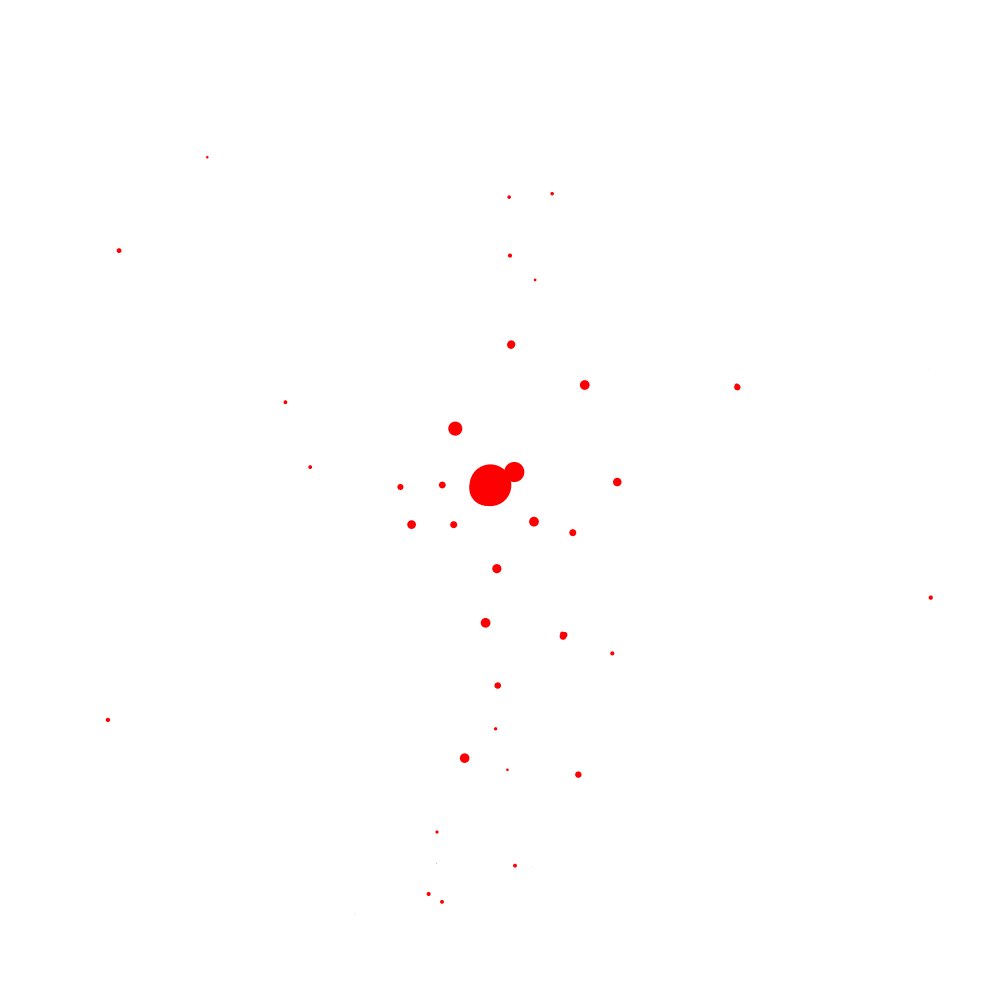

In [314]:
zf = 2.0
animate_between_events(cms.pfcs[0], cms.pfcs[1], fps=50, dpi=300, 
                       box=False, filepath='../plots/Animations/test_single')

In [49]:
# evns
# 673594849, many blobs
# 108181318, kinda three prong
# 111327927, two prong spread out
# 1394266881, two prong
# 848920778, two prong
# 1011256768, two prong
# 120358455, one prong
# 219350787, one prong

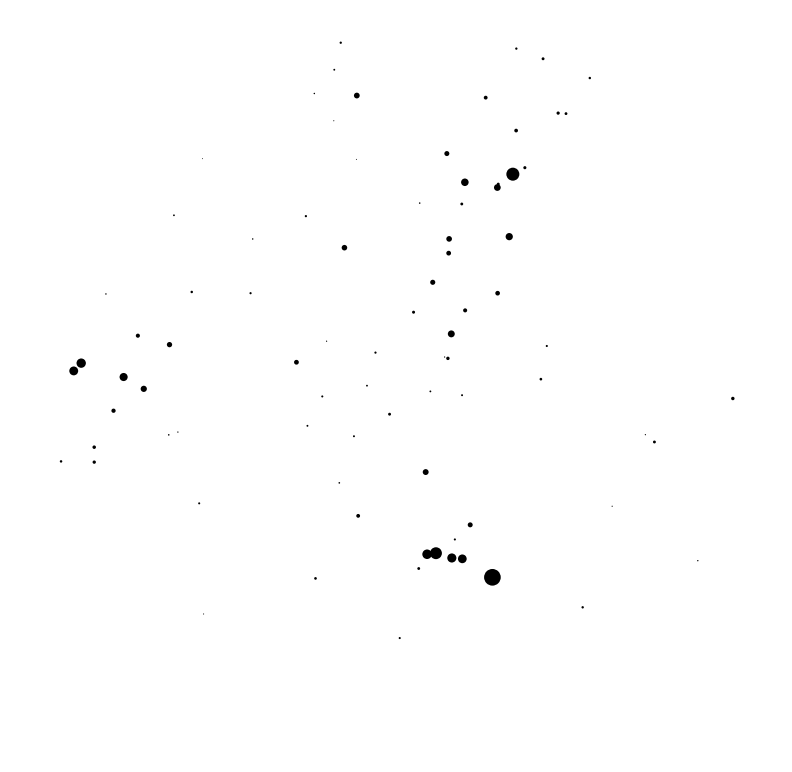

In [349]:
evn = 108181318
plot_event(cms.pfcs[np.argmax(cms.evns == evn)], box=False)

In [409]:
def make_linear_cmap(color0, color1):
    
    cdict = {'red':   ((0, color0[0], color0[0]),
                       (1, color1[0], color1[0])),
             'green': ((0, color0[1], color0[1]),
                       (1, color1[1], color1[1])),
             'blue':  ((0, color0[2], color0[2]),
                       (1, color1[2], color1[2]))}

    return LinearSegmentedColormap(None, cdict)

def plot_line(start, end, cmap, ax=None, npts=2000, lw=1.5):
    
    xs = np.linspace(start[0], end[0], npts)
    ys = np.linspace(start[1], end[1], npts)
    
    argsort = np.argsort(xs)
    
    points = np.array([xs[argsort], ys[argsort]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    ts = xs - np.min(xs)
    colors = cmap(ts/np.max(ts))
    
    lc = LineCollection(segments, linewidths=lw, colors=colors, facecolors=colors, alpha=1.0)
    
    if ax is None:
        ax = plt.gca()
        
    return ax.add_collection(lc)
    
def line_coords(start, end, r):
    start, end = np.asarray(start), np.asarray(end)
    v = end - start
    v *= r/np.linalg.norm(v)
    return start + v, end - v

def slider_coords(start, end, t, w):
    start, end = np.asarray(start), np.asarray(end)
    v = end - start
    pos = start*(1-t) + end*t
    u = np.asarray([v[1], -v[0]])
    u *= w/np.linalg.norm(u)
    start, end = pos + u, pos - u
    return [start[0], end[0]], [start[1], end[1]]

def animation_coords(start, end, d):
    start, end = np.asarray(start), np.asarray(end)
    v = end - start
    mid = start + v/2
    u = np.asarray([v[1], -v[0]])
    u *= d/np.linalg.norm(u)
    return mid + u

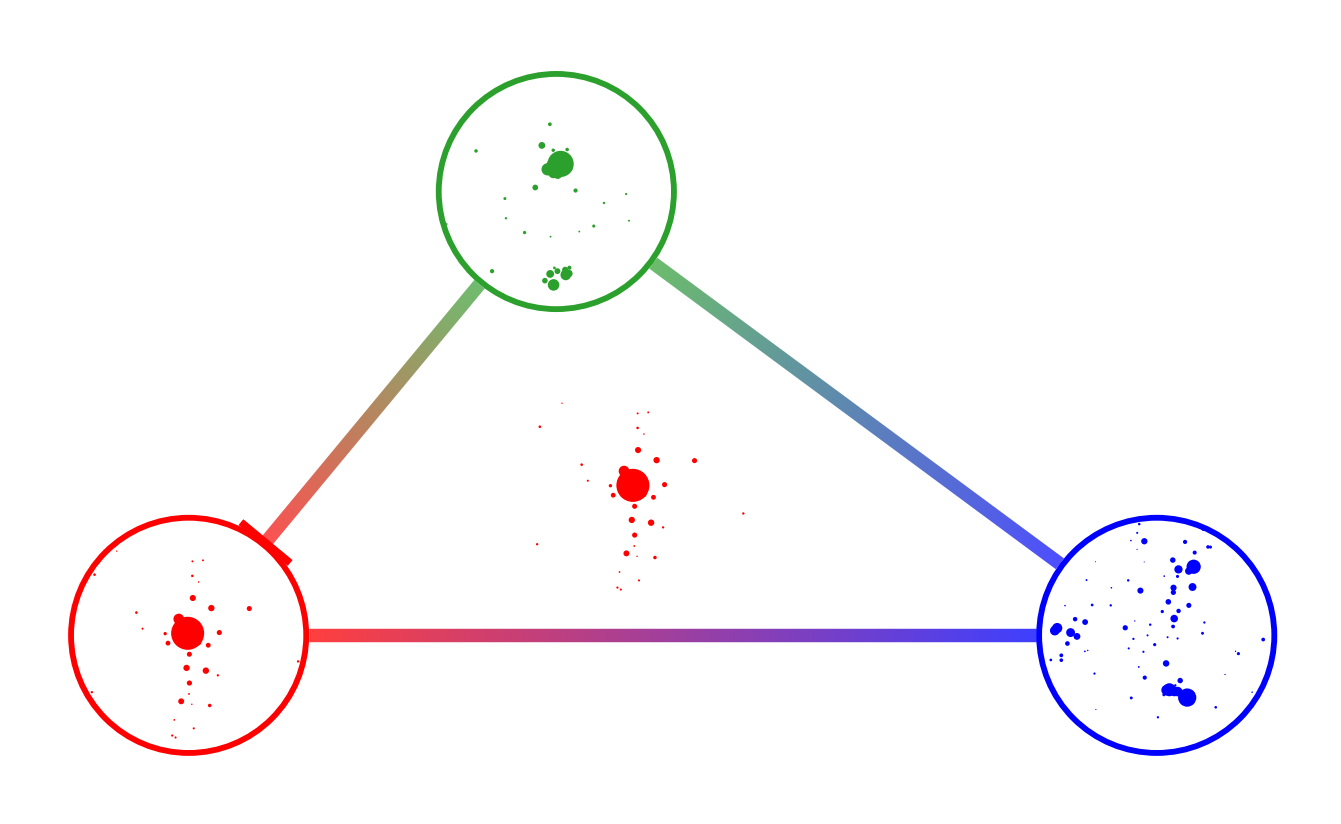

In [413]:
n0 = np.argmax(cms.evns == 219350787)
n1 = np.argmax(cms.evns == 108181318)
n2 = np.argmax(cms.evns == 848920778)

color0, color1, color2 = (1,0,0), (0,0,1), (44/255, 160/255, 44/255)
zf = 0.6
bg_color = (1.0, 1.0, 1.0)
gray = (0.5, 0.5, 0.5)

fps = 50
pause_duration = 1
move_duration = 3
nframes_move_per_distance = 120
dpi = 300

style = 'constant_speed'

filepath = '../plots/Animations/CMS2011AJets_EventSpaceTriangulation_Centroid'
#filepath = '../plots/Animations/CMS2011AJets_EventSpaceTriangulation_IndividualCentered'
#filepath = '../plots/Animations/CMS2011AJets_EventSpaceTriangulation_IndividualCentered_ConstantRate'
#filepath = '../plots/Animations/test'

xmin, xmax = -0.35, 2.4 
#ymin, ymax = -0.8, 1.3
ymin, ymax = -0.35, 1.3
size = 2.

############################################################################

ev0, ev1, ev2 = cms.pfcs[[n0, n1, n2]]
ev0, ev1, ev2 = proc_event(ev0), proc_event(ev1), proc_event(ev2)

x, G01 = ef.emd.emd(ev0, ev1, R=R, return_flow=True, gdim=2)
y, G12 = ef.emd.emd(ev1, ev2, R=R, return_flow=True, gdim=2)
z, G20 = ef.emd.emd(ev2, ev0, R=R, return_flow=True, gdim=2)

fig, ax = plt.subplots(figsize=(size*(xmax - xmin), size*(ymax - ymin)))
fig.subplots_adjust(left=0.01, bottom=0.01, top=.99, right=.99, wspace=None, hspace=None)

ax.set_xticks([])
ax.set_yticks([])

scale, dilation = 100, 0.5
off0 = np.array([0, 0])
off1 = np.array([x/scale, 0])

costheta = (x**2 + z**2 - y**2)/(2*x*z)
sintheta = np.sqrt(1 - costheta**2)
off2 = np.array([z*costheta/scale, z*sintheta/scale])

# colormaps
cmap01 = make_linear_cmap(color0, color1)
cmap12 = make_linear_cmap(color1, color2)
cmap20 = make_linear_cmap(color2, color0)

# sliders
w = 0.06

# animation locations
d = 0.4
incenter = (off0*y + off1*z + off2*x)/(x + y + z)
centroid = (off0 + off1 + off2)/3
aloc01 = centroid#animation_coords(off0, off1, d)
aloc12 = aloc01#animation_coords(off1, off2, d)
aloc20 = aloc01#animation_coords(off2, off0, d)

jopts = {'ax': ax, 'box': False, 'axes_opts': False, 'process': False, 
         'show': False, 'scale': dilation}

r = R*dilation
copts = {'facecolor': 'white', 'lw': 1.75, 'zorder': 1, 'fill': None}
lw, ms = 4, 6
slw = 2.25

def draw_frame(t, show01=False, show12=False, show20=False):
    
    arts = []
    
    # gray out if not shown
    c0 = color0# if show01 or show20 else gray
    c1 = color1# if show01 or show12 else gray
    c2 = color2# if show12 or show20 else gray

    # jets
    arts.append(plot_event(ev0, offset=off0, color=c0, zorder=2, **jopts))
    arts.append(plot_event(ev1, offset=off1, color=c1, zorder=2, **jopts))
    arts.append(plot_event(ev2, offset=off2, color=c2, zorder=2, **jopts))

    # circles
    arts.append(ax.add_patch(Ellipse(off0, 2*r, 2*r, edgecolor=c0, **copts)))
    arts.append(ax.add_patch(Ellipse(off1, 2*r, 2*r, edgecolor=c1, **copts)))
    arts.append(ax.add_patch(Ellipse(off2, 2*r, 2*r, edgecolor=c2, **copts)))

    # lines
    line01 = line_coords(off0, off1, 1.025*r)
    line12 = line_coords(off1, off2, 1.025*r)
    line20 = line_coords(off2, off0, 1.025*r)
    arts.append(plot_line(*line01, cmap=cmap01, ax=ax, lw=lw))
    arts.append(plot_line(*line12, cmap=cmap12, ax=ax, lw=lw))
    arts.append(plot_line(*line20, cmap=cmap20, ax=ax, lw=lw))

    if show01:
        #arts.append(plot_line(*line01, cmap=cmap01, ax=ax, lw=lw))
        arts.append(ax.plot(*slider_coords(*line01, t, w), color=cmap01(t), lw=slw)[0])
        #arts.append(ax.plot(*slider_coords(*line01, t, w), 'D', color='black', ms=ms)[0])
        arts.append(plot_event(merge(ev0, ev1, G01, t), offset=aloc01, color=cmap01(t), zorder=0, **jopts))
    #else:
    #    arts.append(ax.plot([line01[0][0], line01[1][0]], [line01[0][1], line01[1][1]],
    #                        lw=copts['lw'], color=gray))
            
    if show12:
        #arts.append(plot_line(*line12, cmap=cmap12, ax=ax, lw=lw))
        arts.append(ax.plot(*slider_coords(*line12, t, w), color=cmap12(t), lw=slw)[0])
        #arts.append(ax.plot(*slider_coords(*line12, t, w), 'D', color='black', ms=ms)[0])
        arts.append(plot_event(merge(ev1, ev2, G12, t), offset=aloc12, color=cmap12(t), zorder=0, **jopts))
    #else:
    #    arts.append(ax.plot([line12[0][0], line12[1][0]], [line12[0][1], line12[1][1]],
    #                        lw=copts['lw'], color=gray))
        
    if show20:
        #arts.append(plot_line(*line20, cmap=cmap20, ax=ax, lw=lw))
        arts.append(ax.plot(*slider_coords(*line20, t, w), color=cmap20(t), lw=slw)[0])
        #arts.append(ax.plot(*slider_coords(*line20, t, w), 'D', color='black', ms=ms)[0])
        arts.append(plot_event(merge(ev2, ev0, G20, t), offset=aloc20, color=cmap20(t), zorder=0, **jopts))
    #else:
    #    arts.append(ax.plot([line20[0][0], line20[1][0]], [line20[0][1], line20[1][1]],
    #                        lw=copts['lw'], color=gray))
        
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_facecolor(bg_color)
    
    return arts

def animate_together(i):
    
    ax.clear()
    show_all = {'show01': True, 'show12': True, 'show20': True}
        
    # at rest for first pause_frac
    if i < nframes_pause:
        arts = draw_frame(0.0, **show_all)

    # moving
    elif i < nframes_pause + nframes_move:
        t = (i - nframes_pause)/nframes_move
        arts = draw_frame(t, **show_all)

    # paused
    elif i < 2*nframes_pause + nframes_move:
        arts = draw_frame(1.0, **show_all)

    # moving for fourth quarter
    else:
        t = 1 - (i - (2*nframes_pause + nframes_move))/nframes_move
        arts = draw_frame(t, **show_all)
        
    return arts

def animate_separately(i):
    
    ax.clear()
        
    # paused 01 start
    if i < nframes_pause:
        arts = draw_frame(0.0, show01=True)

    # moving 01 forward
    elif i < nframes_pause + nframes_move:
        t = (i - nframes_pause)/nframes_move
        arts = draw_frame(t, show01=True)

    # paused 01 end
    elif i < 2*nframes_pause + nframes_move:
        arts = draw_frame(1.0, show01=True)
        
    # paused 12 start
    elif i < 3*nframes_pause + nframes_move:
        arts = draw_frame(0.0, show12=True)
        
    # moving 12 forward
    elif i < 3*nframes_pause + 2*nframes_move:
        t = (i - (3*nframes_pause + nframes_move))/nframes_move
        arts = draw_frame(t, show12=True)
        
    # paused 12 end
    elif i < 4*nframes_pause + 2*nframes_move:
        arts = draw_frame(1.0, show12=True)
        
    # paused 20 start
    elif i < 5*nframes_pause + 2*nframes_move:
        arts = draw_frame(0.0, show20=True)
        
    # moving 20 forward
    elif i < 5*nframes_pause + 3*nframes_move:
        t = (i - (5*nframes_pause + 2*nframes_move))/nframes_move
        arts = draw_frame(t, show20=True)
        
    # paused 20 end
    elif i < 6*nframes_pause + 3*nframes_move:
        arts = draw_frame(1.0, show20=True)
        
    # moving 20 backward
    elif i < 6*nframes_pause + 4*nframes_move:
        t = (i - (6*nframes_pause + 3*nframes_move))/nframes_move
        arts = draw_frame(1 - t, show20=True)
        
    # paused 20 start
    elif i < 7*nframes_pause + 4*nframes_move:
        arts = draw_frame(0.0, show20=True)
        
    # paused 12 end
    elif i < 8*nframes_pause + 4*nframes_move:
        arts = draw_frame(1.0, show12=True)
        
    # moving 12 backward
    elif i < 8*nframes_pause + 5*nframes_move:
        t = (i - (8*nframes_pause + 4*nframes_move))/nframes_move
        arts = draw_frame(1 - t, show12=True)
        
    # paused 12 start
    elif i < 9*nframes_pause + 5*nframes_move:
        arts = draw_frame(0.0, show12=True)
        
    # paused 01 end
    elif i < 10*nframes_pause + 5*nframes_move:
        arts = draw_frame(1.0, show01=True)
        
    # moving 01 backward
    elif i <= 10*nframes_pause + 6*nframes_move:
        t = (i - (10*nframes_pause + 5*nframes_move))/nframes_move
        arts = draw_frame(1 - t, show01=True)

    # moving for fourth quarter
    else:
        raise RuntimeError('too many frames')
        
    return arts

def animate_constant_speed(i):
    
    ax.clear()
        
    # paused 20 end
    if i < nframes_pause:
        arts = draw_frame(1.0, show20=True)

    # moving 20 backward
    elif i < nframes_pause + nframes20:
        t = (i - nframes_pause)/nframes20
        arts = draw_frame(1 - t, show20=True)

    # paused 20 start
    elif i < 2*nframes_pause + nframes20:
        arts = draw_frame(0.0, show20=True)
        
    # paused 12 end
    elif i < 3*nframes_pause + nframes20:
        arts = draw_frame(1.0, show12=True)
        
    # moving 12 backward
    elif i < 3*nframes_pause + nframes20 + nframes12:
        t = (i - (3*nframes_pause + nframes20))/nframes12
        arts = draw_frame(1 - t, show12=True)
        
    # paused 12 start
    elif i < 4*nframes_pause + nframes20 + nframes12:
        arts = draw_frame(0.0, show12=True)
        
    # paused 01 end
    elif i < 5*nframes_pause + nframes20 + nframes12:
        arts = draw_frame(1.0, show01=True)
        
    # moving 01 backward
    elif i < 5*nframes_pause + nframes20 + nframes12 + nframes01:
        t = (i - (5*nframes_pause + nframes20 + nframes12))/nframes01
        arts = draw_frame(1 - t, show01=True)
        
    # paused 01 start
    elif i < 6*nframes_pause + nframes20 + nframes12 + nframes01:
        arts = draw_frame(0.0, show01=True)
        
    # moving 01 forward
    elif i < 6*nframes_pause + nframes20 + nframes12 + 2*nframes01:
        t = (i - (6*nframes_pause + nframes20 + nframes12 + nframes01))/nframes01
        arts = draw_frame(t, show01=True)
        
    # paused 01 end
    elif i < 7*nframes_pause + nframes20 + nframes12 + 2*nframes01:
        arts = draw_frame(1.0, show01=True)
        
    # paused 12 start
    elif i < 8*nframes_pause + nframes20 + nframes12 + 2*nframes01:
        arts = draw_frame(0.0, show12=True)
        
    # moving 12 forward
    elif i < 8*nframes_pause + nframes20 + 2*nframes12 + 2*nframes01:
        t = (i - (8*nframes_pause + nframes20 + nframes12 + 2*nframes01))/nframes12
        arts = draw_frame(t, show12=True)
        
    # paused 12 end
    elif i < 9*nframes_pause + nframes20 + 2*nframes12 + 2*nframes01:
        arts = draw_frame(1.0, show12=True)
        
    # paused 20 start
    elif i < 10*nframes_pause + nframes20 + 2*nframes12 + 2*nframes01:
        arts = draw_frame(0.0, show20=True)
        
    # moving 20 forward
    elif i <= 10*nframes_pause + 2*nframes20 + 2*nframes12 + 2*nframes01:
        t = (i - (10*nframes_pause + nframes20 + 2*nframes12 + 2*nframes01))/nframes20
        arts = draw_frame(t, show20=True)

    # moving for fourth quarter
    else:
        raise RuntimeError('too many frames')
        
    return arts

nframes_pause = fps*pause_duration
nframes_move = fps*move_duration

if style == 'separate':
    nframes = 10*nframes_pause + 6*nframes_move + 1
    anim = animation.FuncAnimation(fig, animate_separately, frames=nframes, repeat=True, interval=1000/fps)
    
elif style == 'together':
    nframes = 2*nframes_pause + 2*nframes_move + 1
    anim = animation.FuncAnimation(fig, animate_together, frames=nframes, repeat=True, interval=1000/fps)
    
elif style == 'constant_speed':
    nframes01 = int(round(nframes_move_per_distance*x/scale))
    nframes12 = int(round(nframes_move_per_distance*y/scale))
    nframes20 = int(round(nframes_move_per_distance*z/scale))
    nframes = 10*nframes_pause + 2*(nframes01 + nframes12 + nframes20) + 1
    anim = animation.FuncAnimation(fig, animate_constant_speed, frames=nframes, repeat=True, interval=1000/fps)
    
if filepath is not None:
    if not filepath.endswith('.mp4'):
        filepath += '.mp4'
    anim.save(filepath, fps=fps, dpi=dpi, savefig_kwargs={'facecolor': bg_color})
    
HTML(anim.to_html5_video())